In [35]:
%autoreload 2
from datetime import datetime
import os
import re
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# let's pollute the namespace
from jp_utils.constants.earth import *
from jp_utils.general import *
from jp_utils.orbit_utils import *

In [29]:
# config
EPHEM_PATH   = 'j2_only.ffephem'
DURATION = 39800 # seconds
EPHEM_STEP = 10  # seconds

# read in and parse the ephem
ephem = []
with open(EPHEM_PATH, 'r') as eph_input:
    for skip_header in range(2):
        next(eph_input)
    for line in eph_input:
        line = line.strip()
        (epoch, x, y, z, vx, vy, vz) = re.compile("\s{2,100}").split(line)
        ephem.append(np.array([
            float(x), float(y), float(z),
            float(vx), float(vy), float(vz),
        ]))

In [41]:
def perturbed(t, state):
    state_update = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    state_update += accel_point_mass(t, state)
    state_update += accel_j2(t, state)
    return state_update

init_state_vector = [ -2384.46, 5729.01, 3050.46, -7.36138, -2.98997, 1.64354 ]
result = solve_ivp(
    perturbed, # function to solve
    (0, DURATION), # start/stop
    init_state_vector, # intitial state
    t_eval=range(0, DURATION, EPHEM_STEP), # times to evaluate at
    rtol=1e-11, # relative tolerance
)
orbit_solution = result.y
t = result.t

initial_state   = orbit_solution[:,0]
initial_energy  = calc_energy(initial_state)
initial_h_mag   = np.sum(calc_h(initial_state)**2)**0.5
initial_h       = calc_h(initial_state)
initial_ecc_vec = calc_ecc(initial_state)

print('my energy loss', calc_energy(orbit_solution[:,-1]) - initial_energy)
print('ff energy loss', calc_energy(ephem[-1]) - calc_energy(ephem[0]))

my energy loss -0.005556771088361501
ff energy loss -9.153804097650209e-05


my energy loss -0.005556771088361501
ff energy loss -9.153804097650209e-05


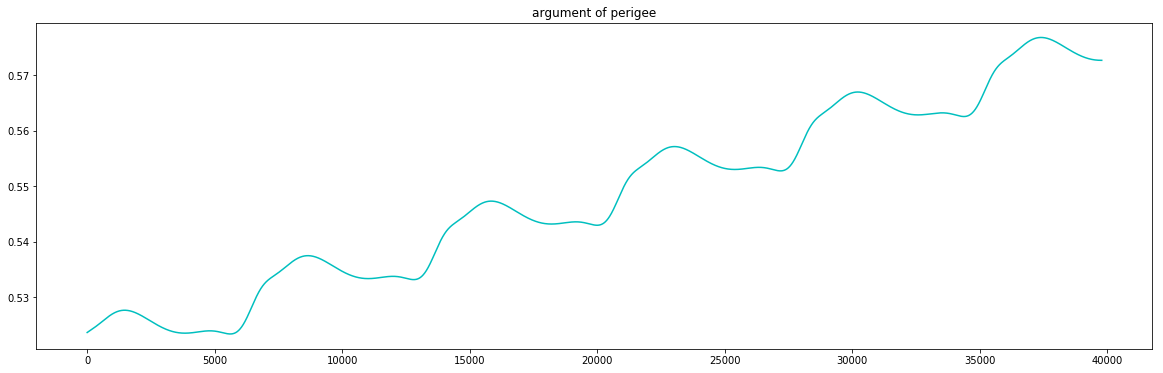

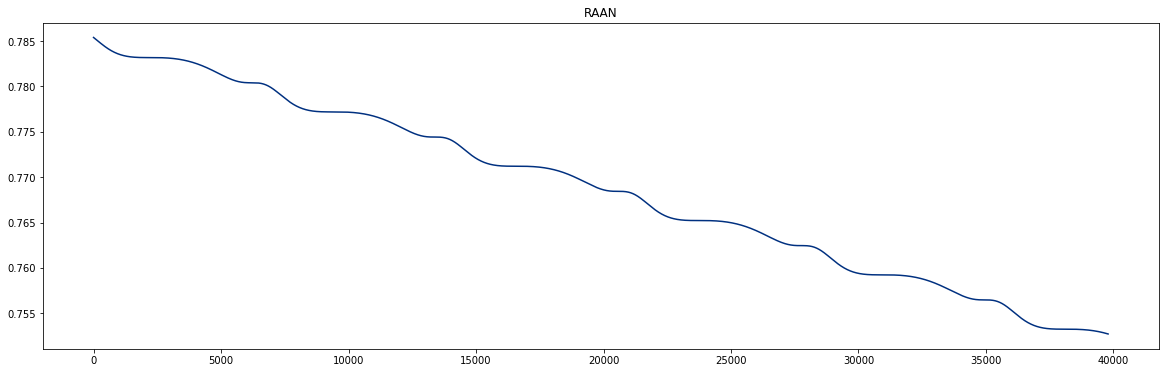

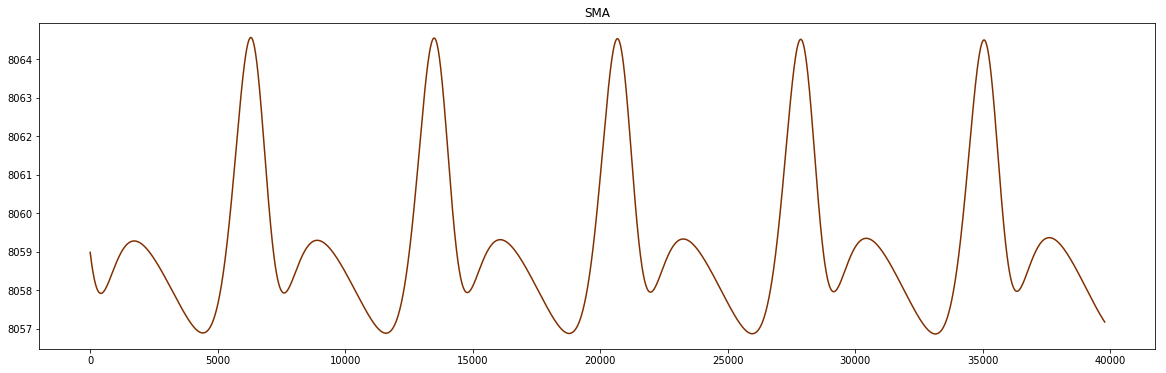

In [40]:
# plot data
energy = []
ff_energy = []
angular_momentum = []
h_mag_plot = []
ecc = []
aop = []
ran = []
sma = []

for i in range(len(orbit_solution[0])):
    energy.append( calc_energy(orbit_solution[:,i]) - initial_energy )
    ff_energy.append( calc_energy(ephem[i]) - calc_energy(ephem[0]))
    
    h = calc_h(orbit_solution[:,i])
    angular_momentum.append( np.sum(h**2)**0.5 - initial_h_mag )
    
    h_mag_plot.append( np.linalg.norm(h - initial_h))

    ecc.append(calc_e(orbit_solution[:,i], h) - initial_ecc_vec)
    
    kep = cartesian_to_keplerian(orbit_solution[:,i])
    aop.append(kep['aop'])
    ran.append(kep['ran'])
    sma.append(kep['sma'])

PLOT_FIGSIZE = (20, 6)

def plot(title, t, data, color):
    plt.figure(figsize=PLOT_FIGSIZE)
    plt.title(title)
    plt.plot(t, data, color)
    plt.show()

#plot('ff_energy', t, ff_energy, 'r')
#plot('energy', t, energy, 'y')
plot('argument of perigee', t, aop, 'c')
plot('RAAN', t, ran, '#003080')
plot('SMA', t, sma, '#803000')

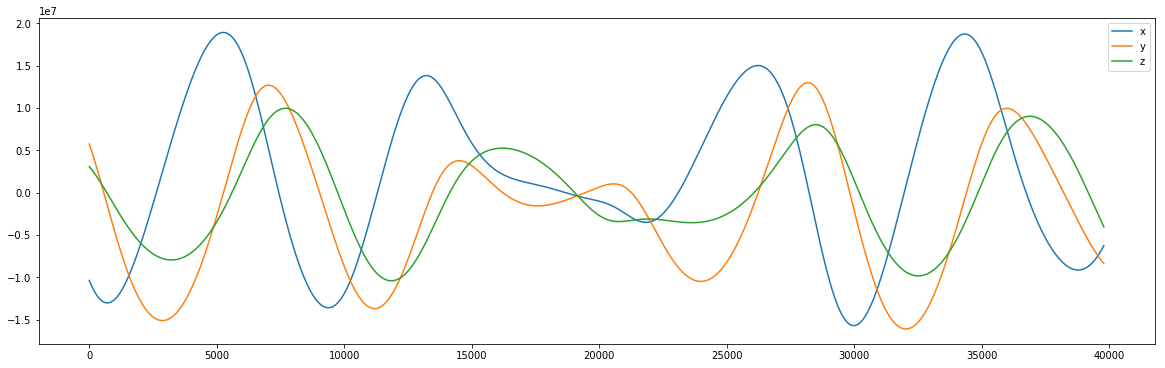

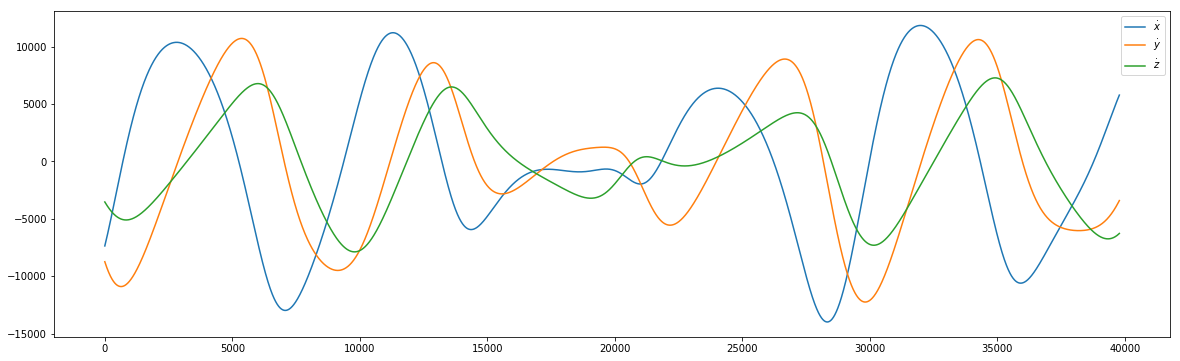

In [32]:
x_diffs = []
y_diffs = []
z_diffs = []
x_dot_diffs = []
y_dot_diffs = []
z_dot_diffs = []
epochs = []
for i in range(len(orbit_solution[0])):
    epochs.append(i*10)
    x_diffs.append(1000*(float(orbit_solution[0][i]) - float(ephem[i][0])))
    y_diffs.append(1000*(float(orbit_solution[1][i]) - float(ephem[i][1])))
    z_diffs.append(1000*(float(orbit_solution[2][i]) - float(ephem[i][2])))
    x_dot_diffs.append(1000*(float(orbit_solution[3][i]) - float(ephem[i][3])))
    y_dot_diffs.append(1000*(float(orbit_solution[4][i]) - float(ephem[i][4])))
    z_dot_diffs.append(1000*(float(orbit_solution[5][i]) - float(ephem[i][5])))


plt.figure(figsize=PLOT_FIGSIZE)
plt.plot(epochs, x_diffs)
plt.plot(epochs, y_diffs)
plt.plot(epochs, z_diffs)
plt.legend(['x', 'y', 'z'])
plt.show()

plt.figure(figsize=PLOT_FIGSIZE)
plt.plot(epochs, x_dot_diffs)
plt.plot(epochs, y_dot_diffs)
plt.plot(epochs, z_dot_diffs)
plt.legend(['$\dot{x}$', '$\dot{y}$', '$\dot{z}$'])
plt.show()